# Problem statement: Empirical Research based on CAPM, Markowitz's Portfolio Theory and Pridiction using time series (LSTM)

Pooja Kangokar Pranesh

DATA690 - Financial Data Science Project

UMBC Spring 2023 


# Data Gathering and EDA 

## Install Required Packages

In [ ]:
!pip install yfinance -qq
!pip install fredapi -qq
!pip install PyPortfolioOpt -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import datetime
import seaborn as sns
import yfinance as yf
import seaborn as sns
from fredapi import Fred

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

import math
import warnings
warnings.filterwarnings("ignore")

## Pull Data for Selected Tickers
1. Establish desired tickers in portfolio that fall under start ups, mid caps, and large caps
2. Pull daily stock performance data from 01/01/2022 to 01/01/2023
3. Calculate daily returns using percent change



**Start ups**
- Pactiv Evergreen Inc. (PTVE) <br>
  * Pactiv Evergreen is a company focused on specialty packaging products. It makes items such as beverage cartons, cups and lids, tableware and food containers
- Diversey Holdings Ltd. (DSEY) <br>
  * iversey is a company focused on sanitation and hygiene services. It is the second-largest firm in America in this category, though it is far smaller than the leader, Ecolab Inc. (ECL). Therein lies the investment opportunity. Ecolab has a market cap of greater than $40 billion and trades for 33 times forward earnings.
- Delek US Holdings Inc. (DK)
  * Delek is an energy company which is principally involved in the refining, transportation, and distribution of oil and refined goods, such as gasoline and jet fuel. The company operates four refineries across the southern part of the United States

reference : https://money.usnews.com/investing/stock-market-news/slideshows/best-small-cap-stocks-to-buy

**Mid caps**
- e.l.f. Beauty Inc. (ELF) 
  * Skincare, Makeup product company
- Helmerich & Payne (HP)
  * Helmerich & Payne, Inc. is an American petroleum contract drilling company engaged in oil and gas well drilling and related services for exploration and production companies headquartered in Tulsa, Oklahoma, with operations throughout the world.
- Super Micro Computer (SMCI)
  * Super Micro Computer, Inc., dba Supermicro, is an information technology company based in San Jose, California. It has manufacturing operations in the Silicon Valley, the Netherlands and at its Science and Technology Park in Taiwan

reference : https://www.nasdaq.com/articles5-high-flying-must-buy-mid-caps-for-2023-from-a-volatile-2022

**Large caps**
- Walt Disney (DIS)
- Activision Blizzard (ATVI)
- Coca-Cola (KO)

reference : https://www.yahoo.com/now/3-best-large-cap-stocks-225329094.html


In [ ]:
# pick stocks and market
#market = ['^GSPC'] # S&P500
market = ['^DJI']
start_ups = ['PTVE','DSEY','DK']
mid_caps = ['ELF','HP','SMCI']
large_caps = ['DIS', 'ATVI', 'KO']
stocks = start_ups + mid_caps + large_caps

# date range for our analysis: 2021 - 2022
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2021,8,1)

# Download closing price of each stock and store it in a dataframe
df = yf.download(stocks + market, start=start, end=end, interval='1d')['Close']

# Drop rows with missing values and clean up column names
df.dropna(inplace=True)
df.rename({'^DJI': 'DJI'},axis='columns',inplace=True)
market = 'DJI'

# Use percent change to calculate returns
returns = df.pct_change()
returns.dropna(inplace=True)

returns.head()

[*********************100%***********************]  10 of 10 completed


,ATVI,DIS,DK,DSEY,ELF,HP,KO,PTVE,SMCI,DJI
Date,,,,,,,,,,
2021-03-25,0.003756,0.011856,0.037121,-0.001333,0.019510,0.012849,0.009705,-0.008097,-0.008826,0.006151
2021-03-26,0.017061,-0.005297,0.016150,0.006676,0.017261,0.031533,0.019608,-0.024490,0.029951,0.013900
2021-03-29,0.017532,-0.005755,-0.033505,-0.009284,-0.019550,-0.036191,0.015271,-0.023013,-0.018339,0.002978
2021-03-30,-0.014465,0.003679,-0.036444,-0.020080,0.017306,0.000729,-0.012999,-0.020699,0.012543,-0.003148
2021-03-31,0.003669,-0.005444,0.004613,0.004781,-0.007766,-0.017851,-0.008279,0.001458,0.029520,-0.002583


## Exploratory Data Analysis 

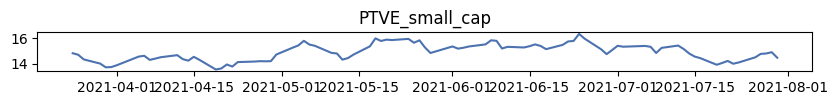

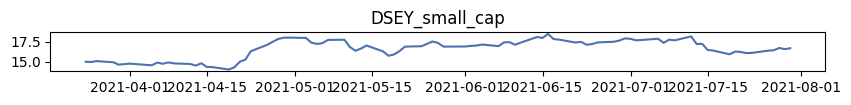

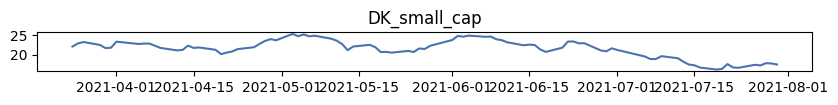

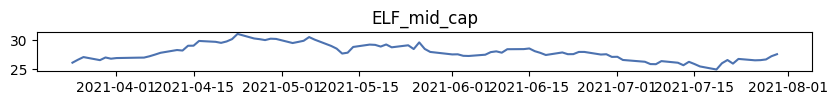

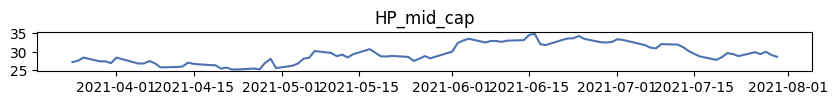

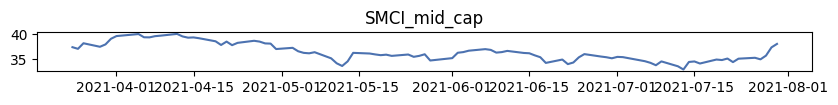

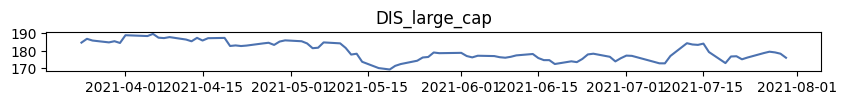

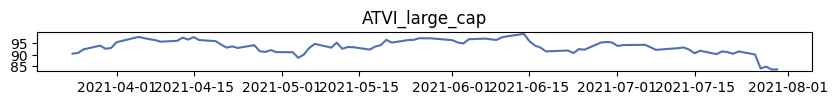

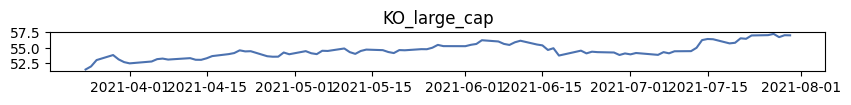

In [66]:
#lets visualize the start up stocks data to understand better

for i, stock in enumerate(df[start_ups].columns, start=1):
  plt.figure(figsize=(10,6))
  plt.subplot(10, 1, i)
  plt.plot(df[stock])
  plt.title(f'{stock}_small_cap')
  plt.show()


for i, stock in enumerate(df[mid_caps].columns, start=1):
  plt.figure(figsize=(10,6))
  plt.subplot(10, 1, i)
  plt.plot(df[stock])
  plt.title(f'{stock}_mid_cap')
  plt.show()

for i, stock in enumerate(df[large_caps].columns, start=1):
  plt.figure(figsize=(10,6))
  plt.subplot(10, 1, i)
  plt.plot(df[stock])
  plt.title(f'{stock}_large_cap')
  plt.show()

Looking the stocks graph we can see that small cap stacks has more volatility when compared with mid and large caps. Mid caps shows more volatility when compared to the large cap stocks.

# 1. CAPM
Run CAPM across entire batch of stocks within identified portfolio

CAPM is the risk-return model which measures the risk using actual stock returns against expected returns. Basically, it's a mean-variance based framework.

We can measure certain paramerts which indicates the changes in the stock using Beta, p-value, sharper and tryenor ratios.

Beta: 

  > This value indicates the volatility of the stock. Also it measures the market risk that cannot be avoided through diversification. 

  >> WHEN <br>
  >>> $\beta$ = 0 No relation with market and stock returns </br>
  >>> $\beta$ < 1 Stock is defensive (Stable) </br>
  >>> $\beta$ > 1 Stock is non-defensive (Aggresive) </br>

Share Ratio:

* If portfolio is not well-diversified

> This indicates excess return per unit of risk of an investment.

>> WHEN <br>
  >>> Sharpe > 1 GOOD Stock </br>
  >>> Sharpe > 2 Stock is VERY GOOD </br>
  >>> Sharpe > 3 Stock is EXCELLENT </br>

\begin{equation}\text{Sharpe ratio}=\frac{r_i-r_f}{\sigma_i}\end{equation}

Treynor Ratio:

* If portfolio is well-diversified

> This is an ideal situation for Treynor ratio, because Treynor ratio takes systematic risk into account to assess the risk-reward situation of an asset or a portfolio.

>> WHEN <br>
  >>> Treynor > 1 GOOD Stock </br>
  >>> Treynor > 2 Stock is VERY GOOD </br>
  >>> Treynor > 3 Stock is EXCELLENT </br>

\begin{equation}\text{Treynor ratio}=\frac{r_i-r_f}{\beta_i}\end{equation}



### Obtain the Risk-Free Rate

In [ ]:
# Lets download the market data
fred = Fred(api_key='bfa89259d6489d6e2f3e96689eb9e62d')#  my API key
risk_free = fred.get_series('DGS3MO')
risk_free = risk_free[start: end]
risk_free = risk_free.dropna()
# Convert the 3-month risk-free rate (DGS3MO) into daily rate by dividing by number of days in 3 months (90).
daily_risk_free = risk_free/90

# #visualize risk free rate
# plt.plot(daily_risk_free)
# plt.title('Daily Risk Free Rate')
# plt.show()

### Functions to calculate CAPM expected return

In [ ]:
'''By subtracting the daily risk free rate from the stock returns. 
   The excess return will be stored in the `excess_returns` dataframe.'''
def calc_excess_return(returns, risk_free_rate): 
    stocks = returns.columns
    excess_returns = pd.DataFrame()
    for i in stocks:
      excess_returns[i] = returns[i] - risk_free_rate

    excess_returns.dropna(inplace=True)

    return excess_returns

'''Obtain Beta, co-efficient values by apply OLS'''
def capm(y_i, X):
  X = sm.add_constant(X, prepend=False)
  capm = sm.OLS(y_i, X) # using OLS
  capm_result = capm.fit()
  residuals = capm_result.resid
  return residuals, capm_result, capm_result.summary(), capm_result.params[0].round(4), capm_result.pvalues[0].round(4) ### RETURNS SUMMARY NOT MODEL

'''Apply to all the stocks in the portfolio'''
def batch_capm(excess_returns, stocks, market): 
  results = {}
  res_coef = {}
  res_p = {}
  residuals = {}
  capm_result = {}
  for stock in stocks:
    residuals[stock], capm_result[stock], results[stock],  res_coef[stock], res_p[stock] = capm(excess_returns[stock],excess_returns[market])

  return residuals, capm_result, results, res_coef, res_p

'''lets compare the performance here -> by defining Security Market Line defination'''
def SML(rf, rm, betas, stock_details):
    asset_ret = [rf + (rm-rf)* i for i in betas]
    asset_ret_ann = [rf + ((rm*252)-rf)* i for i in betas] # multiplying by 252 provides annual expected returns
    stock_details["expected_return_annual"] = asset_ret_ann # this is expected return of the stock
    stock_details["expected_return"] = asset_ret 
    plt.plot(betas, asset_ret)
    plt.xlabel('Systematic Risk')
    plt.ylabel('Asset Return')
    plt.title('SML')
    plt.plot(1,rm, 'ro')

    return stock_details

'''performance with respect to expectations'''
def over_valued(rf, rm, stock):
    x = rf + (rm - rf)*df_all['betas'].loc[stock]
    y = df_all['ret_exp'].loc[stock]
    if x < y:
        return f'The {stock} is undervalued'
    elif x > y:
        return f'The {stock} is overvalued'
    else:
        return f'The {stock} is fairly priced'

'''sharpe calculation'''
def sharpe(stocks, rf, n_assets, indv_stock_returns):
    sharpe_ratios = {}
    for i, j in zip(stocks, range(n_assets)):
        sharpe_ratios[i] = round((indv_stock_returns.iloc[:,j].mean()-rf)/np.std(indv_stock_returns.iloc[:,j]),5)
    return sharpe_ratios

'''treynor calculation'''
def treynor(stocks, rf, n_assets, indv_stock_returns):
    treynor_ratios = {}
    for i, stock in enumerate(stocks):
        treynor_ratios[stock] = round((indv_stock_returns.iloc[:, i].mean() - rf) / df_all['betas'][stock], 4)
    return treynor_ratios

### CAPM derivation and analysis

\begin{equation}
\mathbb{E}(r_i)-r_f= \alpha_i + \beta_{i}(\mathbb{E}(r_m)-r_f) + \epsilon_i
\end{equation}

,stocks,betas,p_value,expected_return_annual,expected_return,ret_exp,stock_type,stock_value,sharpe_ratios,treynor_ratios
stocks,,,,,,,,,,
PTVE,PTVE,1.0673,0.0007,0.232548,0.000893,0.001,Small,Under_Valued,-0.07825,-0.0011
DSEY,DSEY,0.6577,0.0460,0.143473,0.000721,0.001,Small,Under_Valued,-0.07751,-0.0014
DK,DK,1.7925,0.0005,0.390256,0.001198,0.001,Small,Over_Valued,-0.07307,-0.0014
ELF,ELF,1.0643,0.0000,0.231895,0.000892,0.002,Mid,Under_Valued,0.04529,0.0009
HP,HP,1.3270,0.0039,0.289024,0.001002,0.002,Mid,Under_Valued,0.01855,0.0002
SMCI,SMCI,1.0911,0.0000,0.237723,0.000903,0.002,Mid,Under_Valued,0.01965,0.0006
DIS,DIS,0.8758,0.0000,0.190902,0.000812,0.003,Large,Under_Valued,0.09678,0.0008
ATVI,ATVI,0.6651,0.0041,0.145082,0.000724,0.003,Large,Under_Valued,-0.02259,-0.0007
KO,KO,0.6512,0.0000,0.142059,0.000718,0.003,Large,Under_Valued,-0.00538,-0.0001


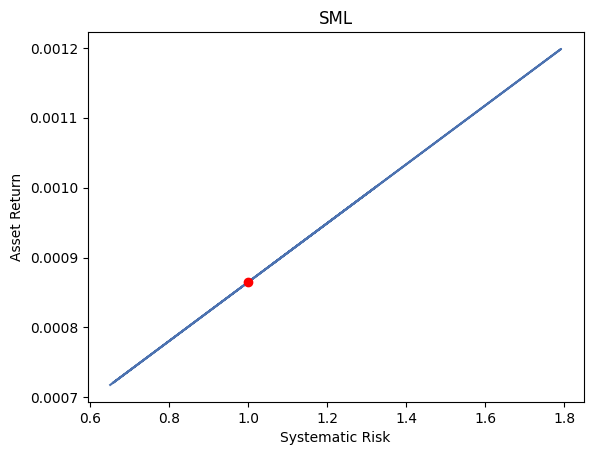

In [ ]:
############## excess returns ##############
excess_returns = calc_excess_return(returns, daily_risk_free)

############## get summary, coef, and p_value details ##############
residuals, capm_result, res, res_coef, res_p = batch_capm(excess_returns, stocks, market)

############## get all betas, p_values to an array ##############
betas = []
p_value = []
for stock in stocks:
  betas.append(res_coef[stock])
  p_value.append(res_p[stock])

############## get the above values to a dataframe for further analysis ##############
stock_details = pd.DataFrame(
    {'stocks': stocks,
     'betas': betas,
     'p_value': p_value
    })

############## SML #################
rf = daily_risk_free.mean()
rm = returns[market].mean()
stock_details = SML(rf, rm, betas, stock_details)


############## expectation vs performace ##############
ret_exp = [0.0010, 0.0010, 0.0010, 0.0020, 0.0020, 0.0020, 0.0030, 0.0030, 0.0030]
df_ret_exp = pd.DataFrame(ret_exp)
df_all = pd.concat([stock_details, df_ret_exp], axis=1)
df_all.rename(columns={0:'ret_exp'}, inplace=True)
df_all.index = df_all.stocks

df_all["stock_type"] = ''
df_all["stock_type"].iloc[0:3]="Small"
df_all["stock_type"].iloc[3:6]="Mid"
df_all["stock_type"].iloc[6:9]="Large"

############## fecth which stocks are overvalued and which and all are undervalued ############## 
over_valued_stocks = []
under_valued_stocks = []
for stock in stocks:
  ans = over_valued(rf, rm, stock)
  if 'overvalued' in ans:
    over_valued_stocks.append(stock)
  else:
    under_valued_stocks.append(stock)

############# Pull all essesntial values to dataframe ################
df_all['stock_value'] = df_all['stocks'].apply(lambda x: 'Over_Valued' if x in over_valued_stocks else 'Under_Valued')
n_assets = 9
sharpe_ratios = sharpe(stocks, rf, n_assets, returns)
df_all["sharpe_ratios"] = sharpe_ratios.values()
treynor_ratios = treynor(stocks, rf, n_assets, returns)
df_all["treynor_ratios"] = treynor_ratios.values()

df_all

## CAPM analysis report


* All stocks has p-value less than 0.05 hence beta value is significant. 

* Small Cap Stocks:
>> Out of 3, two stocks (PTVE, DK) has beta greater than 1 indicating that they are more volatile and risky. Another small stock DSEY has beta value < 1 which is showing stability when compared with the market. </br>

>> Intrestingly, we can see that all the small cap stocks got the sharpe and tryenor ratio indicating negative values (Highly risky).

* Mid Cap Stocks:
>> All the mid cap stocks has beta value greater than 1 indicating that the stock is highly volatile comapared to market. Whereas, both sharpe and tryenor ratios are positive, showing that taken a certain risk we can gain profit. 

* Large Cap Stocks:

>> Every large cap stock picked in the analysis shows the beta value less than 1 which indicates stability and less volatility. Out of 3 stocks 1 got postive(DIS) sharpe and tryenor ratio which is indicating that its a good one to inverst. Wherease other 2 (ATVI, KO) values shows the negative ratio values with risk.

* SML Analaysis:

>> SML exhibits the linear relationship between expected asset returns and betas obtained from CAPM. All the correctly priced securities are plotted on the SML. If the assets lie above the SML line, the assets are undervalued due to the higher return for a given amount of risk. Conversely, the assets lie below the SML are overvalued because it return of this stock is lower for a given amount of risk. <br>

>> Based on this we can see the under_rated and over_valued stock. In our picked portfolio DK is the under_valued stock rest all is over_valued with respect to the return expection percentage set.






## Is CAPM is reliable measure?

To better understand the model result let's look at residual anlysis

* Residual Analysis:

>> The difference between the actual portfolio returns and the prediction returns based on the model. 

>> Performace: If model has residuals randomly distributed around 0 and have constant variance, then its is performing well.

Let's check the analysis on any of the stocks from each category of Small, Mid and Large Cap.

Text(0, 0.5, 'Frequency')

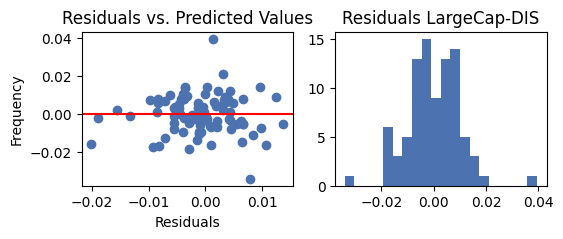

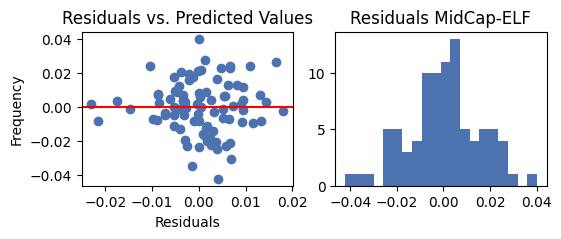

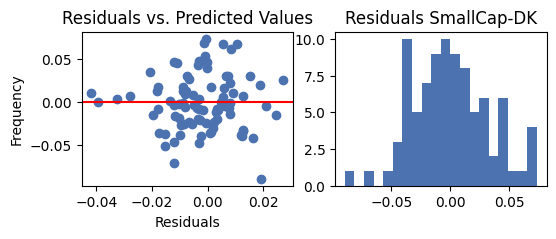

In [ ]:
'''Analyze the constant variance and distribution of Residuals around Zero'''

# Large cap DIS stock
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

axs[0].scatter(capm_result['DIS'].predict(), residuals['DIS'])
axs[0].axhline(y=0, color='red')
axs[0].set_title('Residuals vs. Predicted Values')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[1].hist(residuals['DIS'], bins=20)
axs[1].set_title('Residuals LargeCap-DIS')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# Mid cap DIS stock
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

axs[0].scatter(capm_result['ELF'].predict(), residuals['ELF'])
axs[0].axhline(y=0, color='red')
axs[0].set_title('Residuals vs. Predicted Values')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[1].hist(residuals['ELF'], bins=20)
axs[1].set_title('Residuals MidCap-ELF')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

# Small cap DIS stock
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

axs[0].scatter(capm_result['DK'].predict(), residuals['DK'])
axs[0].axhline(y=0, color='red')
axs[0].set_title('Residuals vs. Predicted Values')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[1].hist(residuals['DK'], bins=20)
axs[1].set_title('Residuals SmallCap-DK')
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')

By looking at our Residual Analysis graphs for each SMALL, MID and LARGE cap sector, we can see that the CAPM is performing well, as we could see there is no much difference between the predicted values to actual return since most of the residuals lie in the center around zero and the graph also shows that it as a constant variance.

# 2. Markowitz Portfolio Analysis

So far we have seen how much risk is invloved in investing in these stocks using CAPM model. Model showed us that except for DK stock rest all are under_valued hence can be purchased. Let's see how well our portfolio will perform with Markowitz Portfolio Analysis when we buy these stocks. 

Markowitz Portfolio Analysis is specifically used to check the protfolio performace of the stocks

Lets Start!

In [ ]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 33.1%
Annual volatility: 11.0%
Sharpe Ratio: 2.82


(0.33077444651592797, 0.11019377370647784, 2.8202541401634456)

The above values shows that we can expect a annual return of 33% from this protfolio taken and 11% volatility risk with a sharpe ratio around 2.82 which is seen to be a excellent choice!

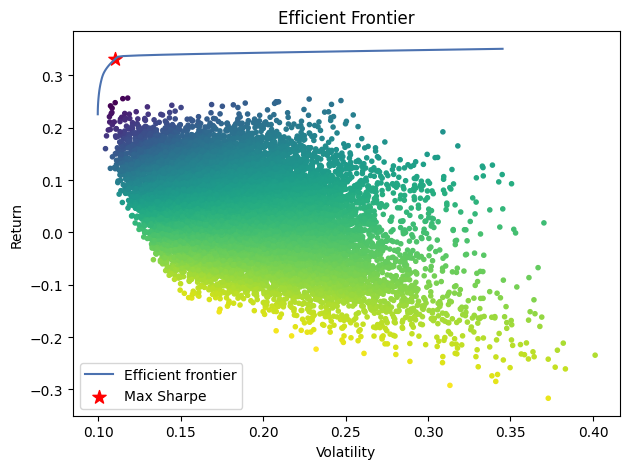

In [ ]:
# creating objects just to avoid the overriding problems
ef1 = EfficientFrontier(mu, S)
ef2 = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef2, ax=ax, show_assets=False)

# Find the tangency portfolio
ef1.max_sharpe()
ret_tangent, std_tangent, _ = ef1.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 20000
w = np.random.dirichlet(np.ones(ef1.n_assets), n_samples)
rets = w.dot(ef1.expected_returns)
stds = np.sqrt(np.diag(w @ ef1.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

## Markowitz Portfolio Analysis Report

>> To better understand our findings by intializing some random weight the effiecint frontier has been drawn, which is showing the exact findings what we found above i.e, it's ideal to take the risk around 11% to gain the max return of around 30% from this protfolio of SMALL, MID and LARGE cap stocks that we have selected.

# 3. Fun Prediction Check: Time Series Analysis 

We wanted to explore how well deep learning models would work when predicting the time series data. Here we have picked LSTM as our model.

Lets start the exploration!

[*********************100%***********************]  1 of 1 completed


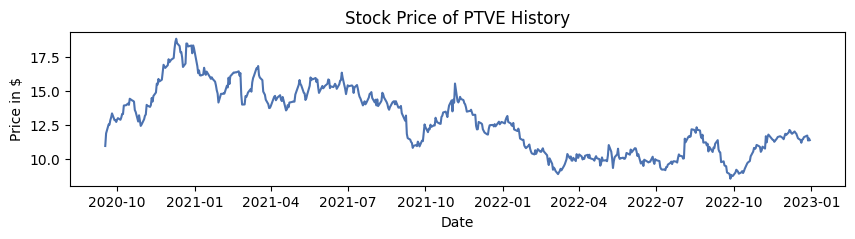

In [ ]:
# download the data for time series analysis
stock_ptve = yf.download('PTVE', start='2020-01-01', end='2023-01-01')

# plot to see the data better
plt.figure(figsize=(10, 2))
plt.plot(stock_ptve['Close'])
plt.xlabel('Date')
plt.ylabel('Price in $')
plt.title('Stock Price of PTVE History')
plt.show()

In [ ]:
'''Lets clean this data and make it LSTM model ready'''

from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# the target value to predict is 'Closing Price' of the stock
close_p = stock_ptve['Close']
train_len = math.ceil(len(close_p.values)* 0.8)

#Normalize the data using Min-Max Scalar
sc = MinMaxScaler(feature_range=(0,1))
sc_data = sc.fit_transform(close_p.values.reshape(-1,1))

# fecth the train data into the following format (values, time-steps, 1 dimensional output)
train_data = sc_data[0: train_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# fecth the test data into the following format (values, time-steps, 1 dimensional output)
test_data = sc_data[train_len-60: , : ]
x_test = []
y_test = close_p.values[train_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# build the LSTM model with layers 
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
402/402 [==============================] - 29s 58ms/step - loss: 0.0065
Epoch 2/3
402/402 [==============================] - 21s 51ms/step - loss: 0.0033
Epoch 3/3
402/402 [==============================] - 23s 58ms/step - loss: 0.0028


In [ ]:
# carry out predictions
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

4/4 [==============================] - 2s 49ms/step


0.0926016849020253

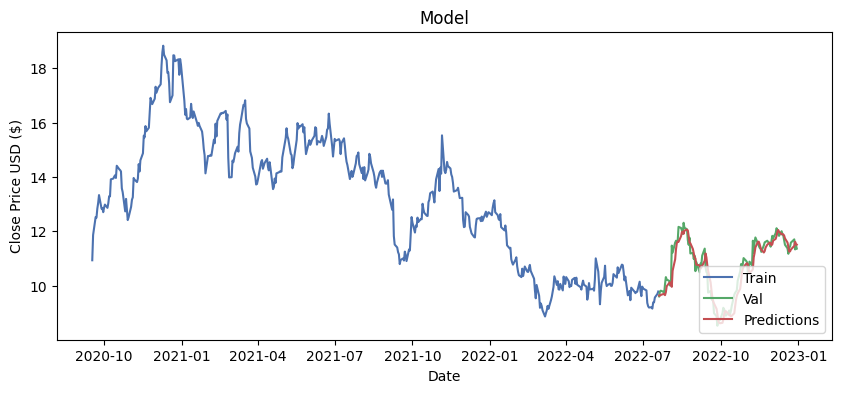

In [67]:
data = stock_ptve.filter(['Close'])
train = data[:train_len]
validation = data[train_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(10,4))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Time Series LSTM Analysis:

>> The LSTM model as perfomerd excellenct. By looking at the graph we can see that there is no much difference between the predictions and actaul data. 

>> This model also provides us the opportunity to carry out performancing tuning by optimizing the hyperparameters.

>> Overall excellent predictions by LSTM!

# 4. Conclusions 

```
* CAPM results are reliable based on the residual analysis we did. 
  It says the except for 'DK' small cap stock rest all are under valued with the rate expectations set. 
```

```
* Since most of the stocks are undervalued and good indication to purchase, we wanted to see the portfolio performance. 
  Which we achieved by applying 'Markowitz Portfolio Analysis'
  This Analysis showed that protfolio would perform excellent with a sharpe ratio of 2.8,
  and annual expected return of 33% taken an ideal risk of 11% proved with effiecient frontier curve. 
  So our portfolio annual return could be around 33% which is not bad!
```

```
* Lastly we wanted to see how LSTM model would work in predicting the time-series data and,
  as we have seen above graph, it did an excellent Job!. 
```